<a href="https://colab.research.google.com/github/pixelwizard2/Project.AI--GuardianPay---Protecting-Against-Lost-Card-and-Copied-Card-Transactions/blob/main/GuardianPay_code_(%ED%95%9C%EA%B5%AD%EC%96%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GuardianPay Project : 카드 결제 이상 행위 감지 및 보호 프로그램
* 신용 카드 거래 데이터셋 : https://www.kaggle.com/datasets/ealtman2019/credit-card-transactions

## 1. Google Drive 마운트

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. 데이터 파일 읽어오기

In [3]:
import pandas as pd

# 데이터 파일 경로 설정
cards_file_path = '/content/drive/My Drive/sd254_cards.csv'
users_file_path = '/content/drive/My Drive/sd254_users.csv'
transactions_file_path = '/content/drive/My Drive/User0_credit_card_transactions.csv'

# 데이터 파일을 데이터프레임으로 읽어오기
cards_df = pd.read_csv(cards_file_path)
users_df = pd.read_csv(users_file_path)
transactions_df = pd.read_csv(transactions_file_path)

## 3. 데이터프레임 확인

In [4]:
print("Cards Dataframe:")
cards_df.head()

Cards Dataframe:


,User,CARD INDEX,Card Brand,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,1,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,0,2,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,0,3,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,0,4,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [5]:
print("Users Dataframe:")
users_df.head()

Users Dataframe:


,Person,Current Age,Retirement Age,Birth Year,Birth Month,Gender,Address,Apartment,City,State,Zipcode,Latitude,Longitude,Per Capita Income - Zipcode,Yearly Income - Person,Total Debt,FICO Score,Num Credit Cards
0,Hazel Robinson,53,66,1966,11,Female,462 Rose Lane,NaN,La Verne,CA,91750,34.15,-117.76,$29278,$59696,$127613,787,5
1,Sasha Sadr,53,68,1966,12,Female,3606 Federal Boulevard,NaN,Little Neck,NY,11363,40.76,-73.74,$37891,$77254,$191349,701,5
2,Saanvi Lee,81,67,1938,11,Female,766 Third Drive,NaN,West Covina,CA,91792,34.02,-117.89,$22681,$33483,$196,698,5
3,Everlee Clark,63,63,1957,1,Female,3 Madison Street,NaN,New York,NY,10069,40.71,-73.99,$163145,$249925,$202328,722,4
4,Kyle Peterson,43,70,1976,9,Male,9620 Valley Stream Drive,NaN,San Francisco,CA,94117,37.76,-122.44,$53797,$109687,$183855,675,1


In [6]:
print("\nTransactions Dataframe:")
transactions_df.head()


Transactions Dataframe:


,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


## 4. 데이터 프레임 병합 후 전처리

### 4.1 데이터셋 병합

 거래 내역과 카드 정보를 'User'와 'CARD INDEX'를 기준으로 병합합니다.

In [7]:
# 'cards_df'에 더미 값(예: 0)을 가진 'Is Fraud?' 컬럼 추가
cards_df['Is Fraud?'] = 0

# 'transactions_df'와 'cards_df'를 'User'와 'Card' 컬럼을 기준으로 병합
merged_data = pd.merge(
    transactions_df,
    cards_df.drop(columns=['Is Fraud?']),  # 'Is Fraud?' 컬럼을 제외하고 가져옵니다.
    left_on=['User', 'Card'],
    right_on=['User', 'CARD INDEX'],
    how='left',
    suffixes=('_transactions', '_cards')
)

# 데이터 병합이 완료된 merged_data 데이터프레임 출력
merged_data.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,...,Card Type,Card Number,Expires,CVV,Has Chip,Cards Issued,Credit Limit,Acct Open Date,Year PIN last Changed,Card on Dark Web
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,...,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No


In [8]:
# 'merged_data' 데이터프레임의 컬럼 이름 확인
merged_data.columns

Index(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount', 'Use Chip',
       'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
       'Errors?', 'Is Fraud?', 'CARD INDEX', 'Card Brand', 'Card Type',
       'Card Number', 'Expires', 'CVV', 'Has Chip', 'Cards Issued',
       'Credit Limit', 'Acct Open Date', 'Year PIN last Changed',
       'Card on Dark Web'],
      dtype='object')

In [9]:
# 'Is Fraud?' 컬럼의 고유한 값 확인(* 통합 과정에서 Yes/No 데이터가 NaN으로 변형 안 되도록 미리 체크하는 부분)
unique_values = merged_data['Is Fraud?'].unique()
print(unique_values)

# 'Is Fraud?' 컬럼 값이 'YES'인 데이터 개수
num_yes = (merged_data['Is Fraud?'] == 'Yes').sum()

# 'Is Fraud?' 컬럼 값이 'NO'인 데이터 개수
num_no = (merged_data['Is Fraud?'] == 'No').sum()

print("count Yes:", num_yes)
print("count No:", num_no)



['No' 'Yes']
count Yes: 27
count No: 19936


### 4.2 병합된 데이터셋 전처리

1) 거래 금액의 문자열을 숫자형으로 변환합니다.

2) 거래 날짜와 시간을 datetime 형식으로 변환합니다.

3) 사기 여부를 숫자형으로 변환합니다.

4) 필요한 컬럼을 선택하여 새로운 데이터프레임을 생성합니다.

In [10]:
# 'Is Fraud?' 컬럼의 'NaN' 값을 'No'로 미리 대체
merged_data['Is Fraud?'].fillna('No', inplace=True)

# 'Is Fraud?' 컬럼을 숫자형으로 변환합니다.
# map 메소드를 사용하여 'Yes'와 'No'를 각각 1과 0으로 변환합니다.
merged_data['Is Fraud?'] = merged_data['Is Fraud?'].map({'Yes': 1, 'No': 0})

# 변환된 'Is Fraud?' 컬럼 값 확인
print(merged_data['Is Fraud?'].value_counts())

0    19936
1       27
Name: Is Fraud?, dtype: int64


In [11]:
# 거래 금액을 숫자형으로 변환합니다.
merged_data['Amount'] = merged_data['Amount'].replace('[\$,]', '', regex=True).astype(float)

# 'Time' 컬럼을 시간 형식으로 변환합니다.
merged_data['Datetime'] = pd.to_datetime(merged_data['Year'].astype(str) + '-' +
                                         merged_data['Month'].astype(str) + '-' +
                                         merged_data['Day'].astype(str) + ' ' +
                                         merged_data['Time'])

# 필요한 컬럼을 선택하여 새로운 데이터프레임을 생성합니다.
analyzed_data = merged_data[['Amount', 'Datetime', 'Use Chip', 'Is Fraud?', 'Time', 'Merchant City', 'Merchant State']]

# analyzed_data를 CSV 파일로 저장
# analyzed_data.to_csv('analyzed_data.csv', index=False)

# 파일 다운로드 링크 생성
# from google.colab import files
# files.download('analyzed_data.csv')

# 데이터 전처리가 완료된 analyzed_data 데이터프레임 출력
analyzed_data.head()

,Amount,Datetime,Use Chip,Is Fraud?,Time,Merchant City,Merchant State
0,134.09,2002-09-01 06:21:00,Swipe Transaction,0,06:21,La Verne,CA
1,38.48,2002-09-01 06:42:00,Swipe Transaction,0,06:42,Monterey Park,CA
2,120.34,2002-09-02 06:22:00,Swipe Transaction,0,06:22,Monterey Park,CA
3,128.95,2002-09-02 17:45:00,Swipe Transaction,0,17:45,Monterey Park,CA
4,104.71,2002-09-03 06:23:00,Swipe Transaction,0,06:23,La Verne,CA


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 5. 데이터 항목별 상관관계 탐색

병합된 데이터셋을 활용하여 '거래 발생 시간',  '사기 발생 장소',  '결제 금액' 등의 항목들을 조합하여 사기 거래와의 관계를 탐색합니다.

### **5-1. '거래 금액'과 '사기 여부' 상관 관계**

<ipython-input-12-91156a1a7bb1>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = analyzed_data.corr()


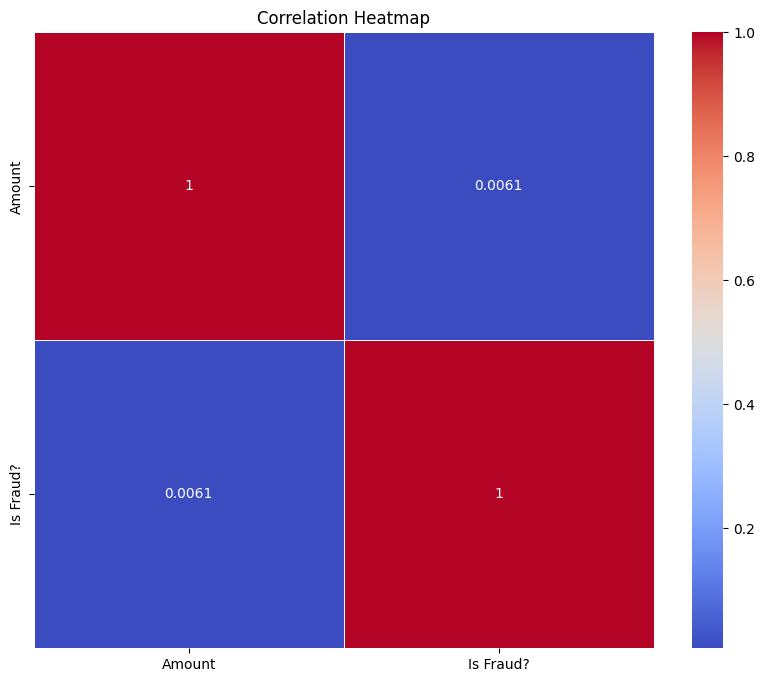

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 항목별 상관관계 계산
correlation_matrix = analyzed_data.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

거래 금액('Amount')과 사기 여부('Is Fraud?') 간의 상관관계는 0.6%로 매우 낮으며, 두 변수 간에는 거의 선형적인 관련성이 없는 것 같습니다. 따라서 거래 금액이 사기 여부를 예측하는 데 큰 영향을 미치지 않는 것으로 판단됩니다. 그러나 높은 금액이 주로 카드 사기 결제에 해당될 수 있는 경우를 고려하여 더 자세히 분석하겠습니다.

아래와 같은 3단계의 추가 분석을 진행하겠습니다 :

금액 범주화 ▶ 시각화 ▶ 통계 분석

(1) 금액 범주화: 거래 금액을 작은 금액, 중간 금액, 높은 금액 등의 범주로 나누어 사기 여부를 조사합니다.

(2) 시각화: 각 금액 범주에서의 사기 거래 비율을 원 그래프로 시각화하여 확인합니다.

<ipython-input-13-bf8ff7ccb200>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analyzed_data.loc[:, 'Amount Category'] = pd.cut(analyzed_data['Amount'], bins=bins, labels=labels)


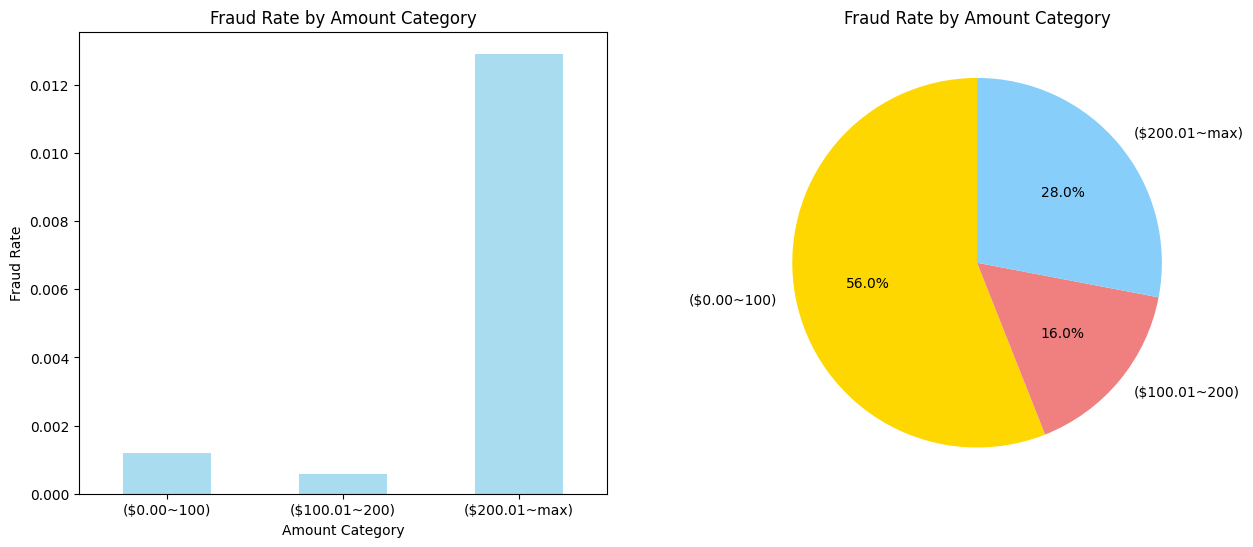

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# 금액을 작은 금액, 중간 금액, 높은 금액 범주로 나눕니다.
bins = [0, 100, 200, analyzed_data['Amount'].max()]
labels = ['($0.00~100)', '($100.01~200)', '($200.01~max)']
analyzed_data.loc[:, 'Amount Category'] = pd.cut(analyzed_data['Amount'], bins=bins, labels=labels)

# 각 금액 범주의 사기 거래 비율을 계산합니다.
fraud_rate_by_amount = analyzed_data.groupby('Amount Category')['Is Fraud?'].mean()

# 카이제곱 검정 수행
contingency_table = pd.crosstab(analyzed_data['Amount Category'], analyzed_data['Is Fraud?'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# 그래프를 한 번에 그리기
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 첫 번째 그래프: 막대 그래프
fraud_rate_by_amount.plot(kind='bar', color='skyblue', alpha=0.7, ax=ax1)
ax1.set_xlabel('Amount Category')
ax1.set_ylabel('Fraud Rate')
ax1.set_title('Fraud Rate by Amount Category')

# x축 레이블 방향 설정 (가로로 출력)
ax1.tick_params(axis='x', rotation=0)

# 두 번째 그래프: 원 그래프
ax2.pie(contingency_table[1], labels=contingency_table.index, autopct='%1.1f%%', startangle=90, colors=['gold', 'lightcoral', 'lightskyblue'])
ax2.set_title('Fraud Rate by Amount Category')

plt.show()

1) **막대 그래프**는 각 금액 범주에서 사기 거래가 차지하는 비율.

2) **원 그래프**는 전체 사기 거래 중 각 금액 범주가 차지하는 절대적인 비중.

결론)) 높은 금액 범주에서의 거래는 상대적으로 위험성이 높다는 것을 인식하면서도, **전체 사기 거래의 대부분은 낮은 금액 범주에서 발생**한다는 사실을 이해해야 합니다.

(3) 통계 분석: 높은 금액 범주에서의 사기 거래와 낮은 금액 범주에서의 사기 거래 간의 통계적 유의성을 점검합니다.


In [14]:
from scipy.stats import chi2_contingency

# 높은 금액 범주와 낮은 금액 범주에서의 사기 여부 간의 통계적 유의성 검정
contingency_table = pd.crosstab(merged_data['Amount'], merged_data['Is Fraud?'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# 결과 출력
print("Chi-Square Test Results for High and Low Amount Categories:")
print(f"Chi-Square Value: {chi2}")
print(f"p-value: {p}")

# 결과 해석
if p < 0.05:
    print("Since the p-value is less than the significance level of 0.05, it indicates a significant difference in fraud rates between high and low amount categories.")
else:
    print("Since the p-value is greater than the significance level of 0.05, there is no significant difference in fraud rates between high and low amount categories.")

Chi-Square Test Results for High and Low Amount Categories:
Chi-Square Value: 14595.304995894268
p-value: 1.0619087671971114e-84
Since the p-value is less than the significance level of 0.05, it indicates a significant difference in fraud rates between high and low amount categories.


Chi-Square 값은 높은 금액 범주와 낮은 금액 범주 간의 관계의 강도를 나타내며, 매우 큰 값으로 높은 금액 범주와 낮은 금액 범주 간의 관계가 강력하다는 것을 시사합니다.

또한, 작은 p-value 값은 이 관계가 통계적으로 유의미하다는 것을 나타내며, 이로 인해 높은 금액 범주와 낮은 금액 범주 간의 사기 거래 비율에 유의한 차이가 있다고 할 수 있습니다.


이와 같은 결과들을 통하여 '거래 금액이 사기 여부에 영향을 미칠 가능성이 높다'는 것을 시사할 수 있으며, **사기 탐지 시 거래 금액이 중요한 요소로 비중을 차지하고 있음을 확인**합니다.

### **5-2.  'Amount', 'Time', 'Merchant City' 컬럼 기반, '정상 결제'와 '사기 결제' 패턴 분석**

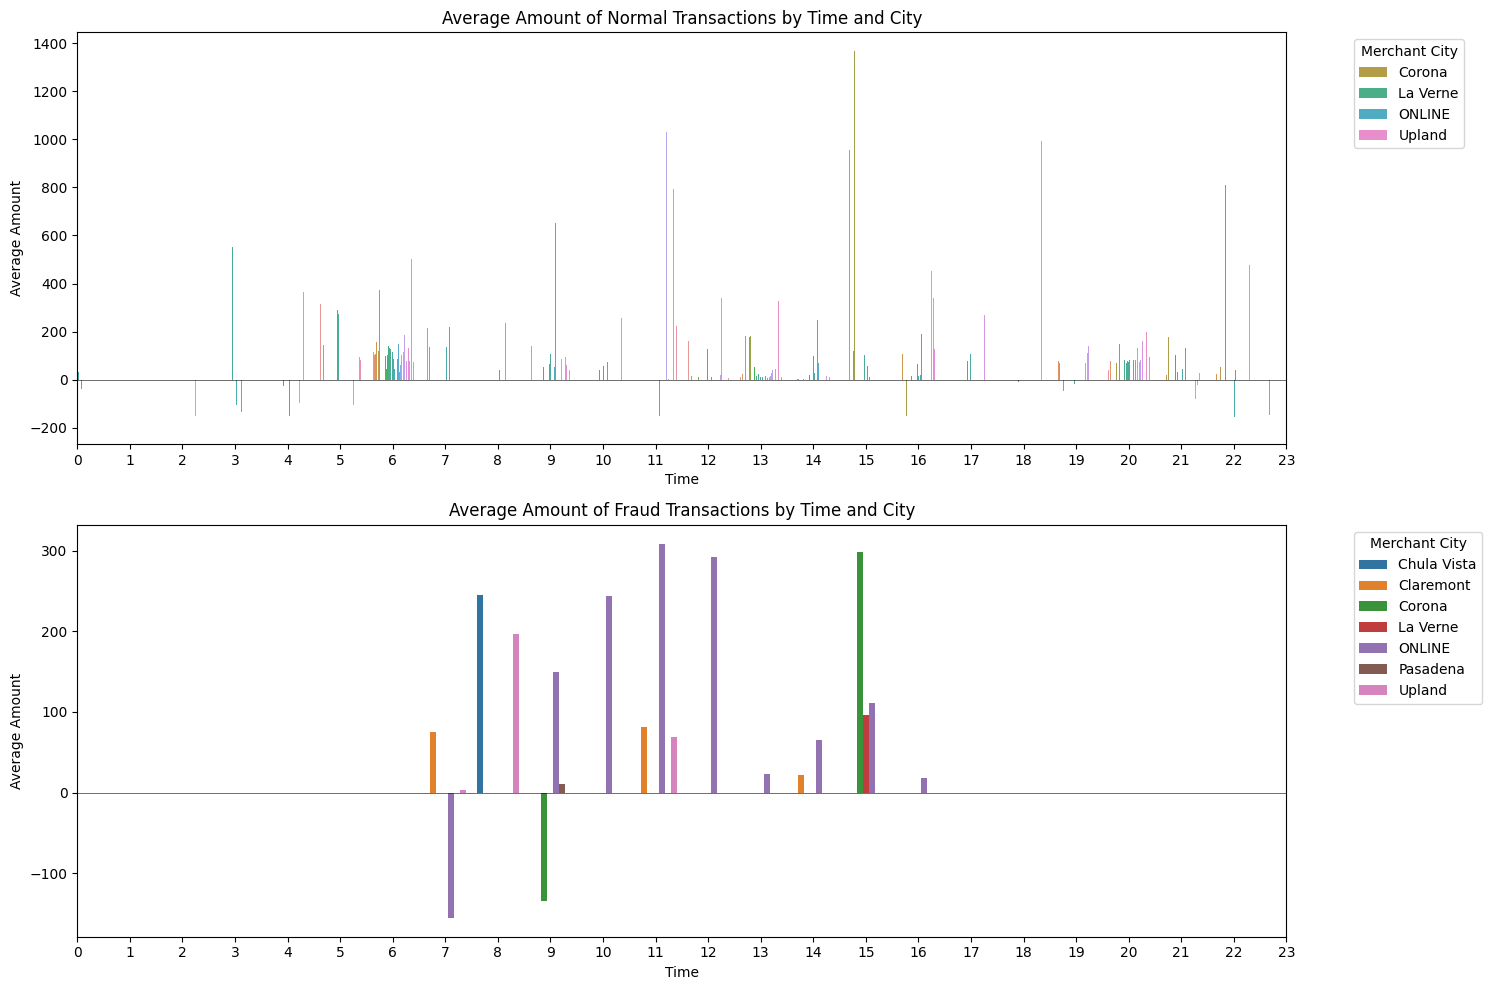

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

# 필요한 데이터만 선택, 복사본 생성
analysis_data = analyzed_data[['Amount', 'Time', 'Merchant City', 'Is Fraud?']].copy()

# 'Time'을 시간대로 변환 (예: '06:21' -> '06') - .loc을 사용하여 경고를 해결
analysis_data.loc[:, 'Time'] = analysis_data['Time'].str[:2]

# 'Time'을 정수로 변환 (예: '06' -> 6)
analysis_data['Time'] = analysis_data['Time'].astype(int)

# 정렬을 위해 'Time'에 대해 정렬 수행
normal_avg_amount_all_cities.sort_values('Time', inplace=True)
fraud_avg_amount.sort_values('Time', inplace=True)

# 정상 거래와 사기 거래 분리
normal_transactions = analysis_data[analysis_data['Is Fraud?'] == 0]
fraud_transactions = analysis_data[analysis_data['Is Fraud?'] == 1]

# 사기 거래에서 나온 'Merchant City' 목록 추출
fraud_merchant_cities = fraud_transactions['Merchant City'].unique()

# 도시별, 시간대별 평균 결제 금액 계산 (모든 도시 포함)
normal_avg_amount_all_cities = normal_transactions.groupby(['Merchant City', 'Time']).mean().reset_index()

# 데이터 시각화 준비
fig, ax = plt.subplots(2, 1, figsize=(15, 10), sharex=False)

# 정상 거래 시각화 (모든 도시 포함)
sns.barplot(x='Time', y='Amount', hue='Merchant City', data=normal_avg_amount_all_cities, ax=ax[0], order=range(24))
ax[0].set_title('Average Amount of Normal Transactions by Time and City')
ax[0].set_ylabel('Average Amount')
ax[0].set_xlabel('Time')

# x축에 모든 시간대의 눈금을 표시
ax[0].set_xticks(range(24))
ax[0].set_xticklabels([str(i) for i in range(24)])

# 사기 거래 시각화
fraud_avg_amount = fraud_transactions.groupby(['Merchant City', 'Time']).mean().reset_index()
sns.barplot(x='Time', y='Amount', hue='Merchant City', data=fraud_avg_amount, ax=ax[1], order=range(24))
ax[1].set_title('Average Amount of Fraud Transactions by Time and City')
ax[1].set_ylabel('Average Amount')
ax[1].set_xlabel('Time')

# x축에 모든 시간대의 눈금을 표시 (두 번째 그래프에 대해서도 적용)
ax[1].set_xticks(range(24))
ax[1].set_xticklabels([str(i) for i in range(24)])

# 범례 설정 (사기 거래에 나타난 도시만 표시)
for i in range(2):
    handles, labels = ax[i].get_legend_handles_labels()
    filtered_handles = [h for h, l in zip(handles, labels) if l in fraud_merchant_cities]
    filtered_labels = [l for l in labels if l in fraud_merchant_cities]
    ax[i].legend(filtered_handles, filtered_labels, title='Merchant City', bbox_to_anchor=(1.05, 1), loc='upper left')

# x축 레이블을 0부터 23까지 정렬하여 표시
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].xaxis.set_major_formatter(ticker.ScalarFormatter())

# 시각화 기준선 추가
ax[0].axhline(0, color='black', linewidth=0.4)
ax[1].axhline(0, color='black', linewidth=0.4)

# x축의 범위를 설정
ax[0].set_xlim(0, 23)
ax[1].set_xlim(0, 23)

plt.tight_layout()
plt.show()

1) 사기 거래는 **특정 시간대(07시~15시 사이)에 더 빈번하게 발생**하는 것으로 보입니다.

2) 일부 사기 거래의 평균 금액이 정상 거래에 비해 더 높은 것으로 보이지만, 일부 시간대에는 예외적으로 낮은 평균 금액을 보이기도 합니다.

3) 마이너스 금액을 이상치 처리하지 않는 이유는, 입금거래 또한 사기로 분류될 수 있기 때문에 그대로 적용합니다.


## 6. 오버샘플링 & 모델훈련(랜덤 포레스트)

### **6.1 데이터 불균형 처리하기 (지도학습)**

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# 'Time' 컬럼을 정수 형태로 변환합니다.
analysis_data['Hour'] = analysis_data['Time'].astype(int)

# 필요한 피처를 선택하고 데이터를 피처(X)와 라벨(y)로 분리합니다.
X = analysis_data[['Amount', 'Hour', 'Merchant City']]
y = analysis_data['Is Fraud?']

# 범주형 피처와 수치형 피처를 전처리하기 위한 변환기를 생성합니다.
categorical_features = ['Merchant City']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numeric_features = ['Amount', 'Hour']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 데이터를 훈련 세트와 테스트 세트로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE(Synthetic Minority Over-sampling Technique)를 사용하여 오버샘플링을 적용합니다.
smote = SMOTE(random_state=42)

# 랜덤 포레스트 분류기를 생성합니다.
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 파이프라인을 생성하여 전처리기, SMOTE, 분류기를 결합합니다.
imb_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', classifier)])

# 파이프라인을 사용하여 모델을 훈련합니다.
imb_pipeline.fit(X_train, y_train)

# 테스트 세트에 대해 예측을 수행합니다.
y_pred = imb_pipeline.predict(X_test)

# 분류 보고서를 생성합니다.
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3990
           1       0.29      0.67      0.40         3

    accuracy                           1.00      3993
   macro avg       0.64      0.83      0.70      3993
weighted avg       1.00      1.00      1.00      3993



 **모델이 사기 거래(Is Fraud? = 1)를 감지하는 능력이 향상되었음**을 알 수 있습니다.

precision, recall, f1-score 값이 모두 개선되었고, 특히 recall 값이 높은 것은 모델이 사기 거래를 잘 감지하고 있다는 것을 의미합니다.

그러나 precision이 낮기 때문에, 일부 정상 거래를 사기로 잘못 분류하는 경우가 여전히 존재합니다.

### **6.2 혼동 행렬(Confusion Matrix) 사용**

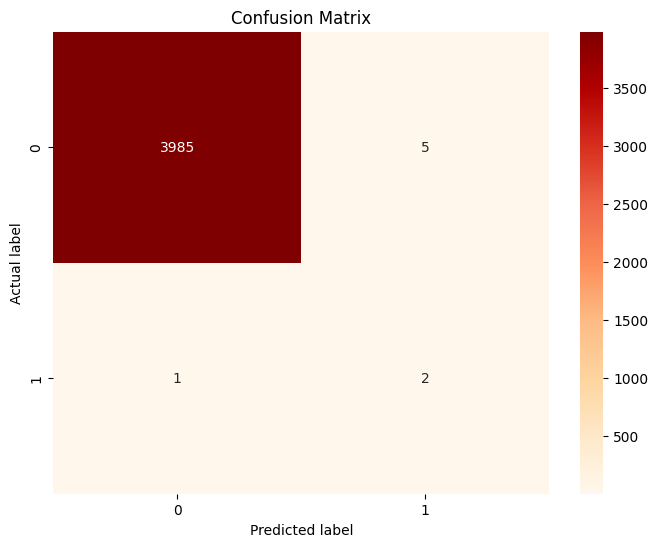

In [60]:
from sklearn.metrics import confusion_matrix

# 혼동 행렬을 계산합니다.
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬을 시각화합니다.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

혼동 행렬을 보면, 대부분의 정상 거래는 정확하게 감지되고 있지만 (진짜 음성(True Negative, TN)),

몇 가지 사기 거래 (진짜 양성(True Positive, TP))를 놓치고 있습니다.

또한 일부 정상 거래를 사기로 잘못 분류하는 경우(거짓 양성(False Positive, FP))도 있습니다.

### **6.3  GridSearchCV를 통한 모델 파라미터 튜닝**

In [62]:
from sklearn.model_selection import GridSearchCV

# 파라미터 그리드 설정
param_grid = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 객체 생성
CV_rfc = GridSearchCV(estimator=imb_pipeline, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)

# 그리드 서치 수행
CV_rfc.fit(X_train, y_train)

# 최적의 파라미터 출력
best_parameters = CV_rfc.best_params_
print("Best Parameters:", best_parameters)

# 최적의 파라미터를 사용한 모델을 얻습니다.
best_model = CV_rfc.best_estimator_

# 테스트 데이터셋에 대해 예측을 수행합니다.
y_pred_best = best_model.predict(X_test)

# 새로운 분류 보고서를 생성합니다.
new_report = classification_report(y_test, y_pred_best, zero_division=0)
print(new_report)

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3990
           1       0.29      0.67      0.40         3

    accuracy                           1.00      3993
   macro avg       0.64      0.83      0.70      3993
weighted avg       1.00      1.00      1.00      3993



**- 결과 분석** : 파라미터 튜닝 이전과 비교되는 차이점 미발생.

**데이터의 한계 :** 사용된 데이터가 모델이 더 잘 학습할 수 있을 만큼 충분히 다양하지 않을 수 있습니다.

특히 사기 거래가 매우 적어, 모델이 이를 충분히 학습하지 못했을 수 있습니다.


**모델의 한계:** 랜덤 포레스트는 강력한 모델이지만, 모든 상황에 최적인 것은 아닙니다. 다른 알고리즘 시도해 봅니다.

### **6.4   서포트 벡터 머신(SVM), 그래디언트 부스팅, XGBoost 알고리즘 사용**